In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils import *

from sklearn.ensemble import RandomForestRegressor

In [2]:
columns = ['DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance']

encoding = ['OD']

# box_cox = ['PricePerPax', 'TravelDistanceKm']

# yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']


In [3]:
# Reading the csv
data = pd.read_csv('../raw_data/skyscanner_data_171223')

# Dropping NA data from specific columns
no_nan = data.dropna(subset=['OriginApt', 'DestinationApt', 'DurationMin', 'PricePerPax', 'DestinationCtry'])


# Only keeping ecoonomy flights
economy_flights = no_nan[(no_nan['PricePerPax'] > 0) & (no_nan['PricePerPax'] < 2000)]

# Removing weird numbers with negative distances
distance_makes_sense_flights = economy_flights[(economy_flights["TravelDistanceKm"]<= economy_flights["Total_Flight_Distance"]) &
                                               (economy_flights["Total_Flight_Distance"] <= 5*economy_flights["TravelDistanceKm"])]

# Creating processed data
processed_data, scalers = all_preprocessing(distance_makes_sense_flights,columns, log_od_by_itredirects, 'log_od_by_itredirect', od_combined_encoding=True)

/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [4]:
clean_processed_data = processed_data.dropna(subset=['log_od_by_itredirect'])

In [5]:
# Graph for looking into high frequency targets
# clean_processed_data[clean_processed_data['log_od_by_itredirect'] < 40]['log_od_by_itredirect'].hist(figsize=(20,6), bins=40)

In [6]:
# randomly removing high frequency datapoints

less_than_18 = clean_processed_data[clean_processed_data['log_od_by_itredirect'] < 18].copy()
greater_than_eq_18 = clean_processed_data[clean_processed_data['log_od_by_itredirect'] >= 18].copy()

less_than_18_sampled = less_than_18.sample(frac=0.5).copy()

smalled_training_set = pd.concat([less_than_18_sampled, greater_than_eq_18])

In [7]:
data['OriginCty'].nunique()

671

In [8]:
# Adding dayofweek back to df

# original_data_subset_by_training_data = data.loc[smalled_training_set.index].copy()
# smalled_training_set['dayofweek'] = original_data_subset_by_training_data['dayofweek']

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(clean_processed_data.drop('lod_od_by_itredirect', axis=1),
#                                                     clean_processed_data['lod_od_by_itredirect'], test_size=0.2, random_state=42)

In [10]:
def process_new_data2(original_data:pd.DataFrame, new_data:pd.DataFrame, scalers, columns_to_keep:List[str],
                     box_cox_columns:List[str]=False, yeo_johnson_columns:List[str]=False, log_transform_columns:List[str]=False, min_max_columns:List[str]=False,
                     od_encoding:bool=False, operator_encoding:bool=False, od_combined_encoding=False):
    """
    This function processes new data, using scalers and encoders from the training set
    It only returns the columns stated in columns_to_keep, and encoded columns if those options flipped to True

    original_data:
                This is used for encoding - can have dummy data if no encoding is taking place.
                IMPORTANT: Use the index of your processed data to slice the original_data.
                In order to encode OD's we need to re-create the OD column in original_data.
                We are slicing by data that we train on so no encoded columns stay consistent

    new_data: The data you are processing

    scalers: Must be a Class variable of scalers from the all_preprocessing function

    columns_to_keep: this is the list of columns you want to keep, if daysofweek, it only returns the cosin columns and drops daysofweek

    _columns variables: List of columns you want in that scaling step

    od_encoding + operator_encoding: Boolean, only flip if you want to encode new data.

    """

    # Creating a copy of the list so that we do not update the list outside of this function
    list_of_columns = columns_to_keep.copy()

    # DATA CLEANING

    # Filling the Null itinerary_fare data with booked_fare
    new_data['itinerary_fare'].fillna(new_data['booked_fare'], inplace=True)

    # Dropping data where itinerary_fare remains Null
    clean_data = new_data.dropna(subset=['itinerary_fare']).copy().reset_index()

    # FEATURE ENGINEERING
    clean_data['DurationMin'] = clean_data['flight_time'] + clean_data['connection_time']

    clean_data['total_layover_time_ratio'] = clean_data['connection_time'] / clean_data['DurationMin']

    clean_data['extra_travel_distance'] = clean_data['total_distance'] - clean_data['direct_distance']
    clean_data['extra_travel_distance_ratio'] =  clean_data['total_distance'] / clean_data['direct_distance']

    # Creating OD column in both original and new data, otherwise the binary encoders will not have the reference point for original information
    clean_data['OD'] = clean_data['origin'] + clean_data['destination']

    original_data['OD'] = original_data['OriginApt'] + original_data['DestinationApt']

    if 'seg_0' not in clean_data.columns:
        clean_data['seg_0'] = 0
        clean_data['seg_1'] = 0

        for i in range(len(clean_data)):
            listtt = clean_data['flights'][i].split(',')
            clean_data['seg_0'][i] = listtt[0][:2]
            clean_data['seg_1'][i] = listtt[1].strip()[:2]

    # Renaming the columns
    col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'Total_Flight_Distance',
                    'direct_distance':'TravelDistanceKm', 'connection_time':'total_layover_time', 'flight_time':'Total_Flight_Duration','itinerary_fare':'PricePerPax',
                    'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}

    clean_data = clean_data.rename(columns=col_rename_dict).copy()

    #TEMP creating Stops and SelfTransfer data
    clean_data['Stops'] = 1
    clean_data['SelfTransfer'] = True

    #DATA CLEANING
    for column in clean_data.select_dtypes(include=['int64']).columns:
        clean_data[column] = clean_data[column].astype('float64')

    # ENCODING
    if od_combined_encoding:
        #Binary encoding origin
        combined_od_encoding = encoding_new_data(original_data=original_data, data_to_be_processed=clean_data, column='OD', encoder=scalers.od_encoder)

        # Updating the dataset with the encoded columns
        od_clean_data = pd.concat([clean_data, combined_od_encoding], axis=1)

        # Ensuring the columns are returned at the end of the function
        list_of_columns.extend(combined_od_encoding.columns.to_list())

    else:
        od_clean_data = clean_data.copy()

    if od_encoding:
        #Binary encoding origin
        origin_encoded = encoding_new_data(original_data=original_data, data_to_be_processed=od_clean_data, column='OriginApt', encoder=scalers.o_encoder)

        # Binary encoding Destination
        destination_encoded = encoding_new_data(original_data, od_clean_data, 'DestinationApt', scalers.d_encoder)

        # Updating the dataset with the encoded columns
        both_ods_clean_data = pd.concat([od_clean_data, origin_encoded, destination_encoded], axis=1)

        # Ensuring the columns are returned at the end of the function
        list_of_columns.extend(origin_encoded.columns.to_list())
        list_of_columns.extend(destination_encoded.columns.to_list())

    else:
        both_ods_clean_data = od_clean_data.copy()

    if operator_encoding:
        seg_0_op_iata = encoding_new_data(original_data, both_ods_clean_data, 'Seg_0_OperatingCarrierIATA', scalers.seg_0_encoder)
        seg_1_op_iata = encoding_new_data(original_data, both_ods_clean_data, 'Seg_1_OperatingCarrierIATA', scalers.seg_1_encoder)

        if 'Seg_2_OperatingCarrierIATA' in both_ods_clean_data.columns:
            seg_2_op_iata = encoding_new_data(original_data, both_ods_clean_data, 'Seg_2_OperatingCarrierIATA', scalers.seg_2_encoder)
        else:
            seg_2_op_iata = False

        if 'Seg_3_OperatingCarrierIATA' in both_ods_clean_data.columns:
            seg_3_op_iata = encoding_new_data(original_data, both_ods_clean_data, 'Seg_3_OperatingCarrierIATA', scalers.seg_3_encoder)
        else:
            seg_3_op_iata = False

        # Updating the dataset with the encoded columns

        dfs_to_concat = [both_ods_clean_data, seg_0_op_iata, seg_1_op_iata]

        if seg_2_op_iata:
            dfs_to_concat.append(seg_2_op_iata)
        if seg_3_op_iata:
            dfs_to_concat.append(seg_3_op_iata)

        seg_clean_data = pd.concat(dfs_to_concat, axis=1)

        # Ensuring the columns are returned at the end of the function
        if operator_encoding:
            list_of_columns.extend(seg_0_op_iata.columns.to_list())
            list_of_columns.extend(seg_1_op_iata.columns.to_list())
            if seg_2_op_iata:
                list_of_columns.extend(seg_2_op_iata.columns.to_list())
            if seg_3_op_iata:
                list_of_columns.extend(seg_3_op_iata.columns.to_list())
    else:
        seg_clean_data = both_ods_clean_data.copy()

    list_of_columns.append('bookings')

    # SCALING
    # Box cox
    if box_cox_columns:
        for col in box_cox_columns:
            seg_clean_data.loc[:,col]  = stats.boxcox(seg_clean_data[col], lmbda=scalers.box_lambda[col])

    # Yeo-johnson
    if yeo_johnson_columns:
        for col in yeo_johnson_columns:
            seg_clean_data.loc[:,col] = stats.yeojohnson(seg_clean_data[col], lmbda=scalers.yeo_lambda[col])

    # Log transformations
    if log_transform_columns:
        for col in log_transform_columns:
            seg_clean_data.loc[:,col] = np.log1p(seg_clean_data[col])

    #Min max scaling
    if min_max_columns:
        for col in min_max_columns:
            seg_clean_data.loc[:,col] = scalers.minmax_scaler[col].transform(seg_clean_data[[col]])

    if 'SelfTransfer' in list_of_columns:
        #Inversing the importance of SelfTransfer, so Non Self Transfer is seen as better by the model
        seg_clean_data['SelfTransfer'] = seg_clean_data['SelfTransfer'].apply(convert_bool_to_num)

    data_to_return = seg_clean_data[list_of_columns].copy()

    if 'dayofweek' in list_of_columns:
        # Cyclical encoding
        data_to_return['sin_day'] = np.sin(2 * np.pi * data_to_return['dayofweek'] / 7)
        data_to_return['cos_day'] = np.cos(2 * np.pi * data_to_return['dayofweek'] / 7)

        # Dropping day of week as it is no longer neccesary
        data_to_return = data_to_return.drop(columns=['dayofweek']).copy()

    return data_to_return

In [11]:
dohop_data = pd.read_csv('../raw_data/OptiFlyAI_testset.csv')
processed_dohop = process_new_data2(original_data=data.loc[smalled_training_set.index], new_data=dohop_data, scalers=scalers,
                 columns_to_keep=columns, od_combined_encoding=True)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/1237395310.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/1237395310.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/1237395310.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [12]:
# Adding dayofweek back to df

# dohop_data_subset_by_processed_data = dohop_data.loc[processed_dohop.index].copy()
# processed_dohop['dayofweek'] = dohop_data_subset_by_processed_data['dayofweek']

In [14]:
dohop_dropped_na = processed_dohop.dropna(subset=['total_layover_time', 'extra_travel_distance_ratio'])

In [15]:
dohop_dropped_na.isna().sum()

DurationMin                         0
PricePerPax                         0
total_layover_time                  0
extra_travel_distance_ratio         0
Total_Flight_Distance               0
OD_0                                0
OD_1                                0
OD_2                                0
OD_3                                0
OD_4                                0
OD_5                                0
OD_6                                0
OD_7                                0
OD_8                                0
OD_9                                0
OD_10                               0
OD_11                               0
OD_12                               0
OD_13                               0
bookings                       588125
dtype: int64

# Random forrest Model

In [16]:
def evaluate_model(data, model):
    data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()

    # Create a new colummn bucketed into "booked" and "not-booked"
    data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
    booked_data = data[data["status"] == "booked"].copy()

    # Filter down the dataset to those rows which were not booked
    not_booked_data = data[data["status"] == "not-booked"].copy()

    # Compute minimum score threshold for booked and not-booked data
    min_booked_score = data.loc[data["status"] == "booked", "predicted_score"].min()
    min_not_booked_score = data.loc[data["status"] == "not-booked", "predicted_score"].min()

    # Check for the edge case and issue a warning, if it applies
    if min_booked_score < min_not_booked_score:
        return "Edge case encountered: Min score of booked rows is lower than min score of not-booked rows."

    metrics = {"min_threshold": min_booked_score,
               "total_rows": data.shape[0],
               "TP": booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "FP": not_booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "TN": not_booked_data[data["predicted_score"] < min_booked_score].shape[0],
               "FN": booked_data[data["predicted_score"] < min_booked_score].shape[0],
               }

    return metrics

In [17]:
# Instantiating model
forrest = RandomForestRegressor(n_estimators=150, criterion="poisson", max_depth=25, n_jobs=-1)

# Training model
forrest.fit(smalled_training_set.drop('log_od_by_itredirect', axis=1), smalled_training_set['log_od_by_itredirect'])

RandomForestRegressor(criterion='poisson', max_depth=21, n_estimators=120,
                      n_jobs=-1)

### Exploring feature importance

<Axes: >

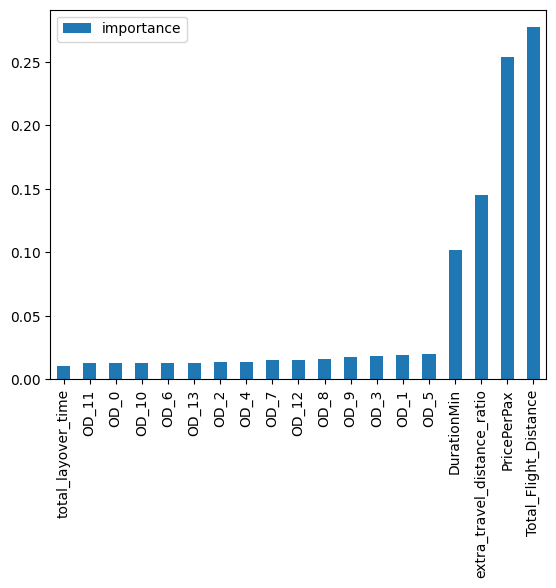

In [18]:
# Getting list of features
feats = smalled_training_set.drop('log_od_by_itredirect', axis=1).columns.to_list()

# Plotting importance
df = pd.DataFrame(index=feats)
df['importance'] = forrest.feature_importances_
df.sort_values('importance').plot(kind='bar')

In [19]:
evaluate_model(dohop_dropped_na, forrest)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_10773/4169582579.py:23: UserWarning: Boolean

{'min_threshold': 2.2222162759015993,
 'total_rows': 595207,
 'TP': 7082,
 'FP': 588092,
 'TN': 33,
 'FN': 0}

# Model results

### Results for Poisson Random Forrest with 120 trees, and 21 max depth

#### Trained on all data, with low target reduction

columns = ['DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance']

encoding = ['OD']

Target = lod_od_by_itredirect

- min_threshold': 2.2222162759015993,
- 'total_rows': 595207,
- 'TP': 7082,
- FP': 588092,
- 'TN': 33,
- 'FN': 0

Training time - 23 minutes

### Results for Poisson Random Forrest with 120 trees, and 21 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance_ratio', 'Total_Flight_Distance']

encoding = ['OD']

Target = lod_od_by_itredirect

'Edge case encountered: Min score of booked rows is lower than min score of not-booked rows.'

Training time - 25 minutes

### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance_ratio']

Target = lod_od_by_itredirect

- 'min_threshold': 4.360915931874575,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588111,
- 'TN': 14,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data, with low target reduction

columns = ['TravelDistanceKm','DurationMin', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 5.344674649929984,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587062,
- 'TN': 1063,
- 'FN': 0

Training time = 13 minutes


 ### Results for Poisson Random Forrest with 120 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.672910392621909,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 586823,
- 'TN': 1302,
- 'FN': 0

Training time - 19 Minutes

### Results for Poisson Random Forrest with 60 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.575537392470289,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587598,
- 'TN': 527,
- 'FN': 0

Training time - 15 minutes

### Results for Poisson Random Forrest with 150 trees, and 12 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.185502636034341,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587532,
- 'TN': 593,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 80 trees, and 20 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.1303687347750593,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587909,
- 'TN': 216,
- 'FN': 0

Training time - 32 Minutes

### Results for Poisson Random Forrest with 80 trees, and 10 max depth

#### Trained on all data


columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.573138342576451,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587159,
- 'TN': 966,
- 'FN': 0

Training time - 19 Minutes

### Results for Poisson Random Forrest with 100 trees, and 8 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 5.302893033067785,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588104,
- 'TN': 21,
- 'FN': 0

Training time - 20 Minutes

### Results for Poisson Random Forrest with 100 trees, and 15 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 3.836471876184013,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587586,
- 'TN': 539,
- 'FN': 0

Training time - 33 Minutes

 ### Results for Poisson Random Forrest with 200 trees, and 10 max depth

#### Trained on all data

columns = ['TravelDistanceKm','DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time', 'extra_travel_distance']

Target = lod_od_by_itredirect

- 'min_threshold': 4.687645660979575,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587021,
- 'TN': 1104,
- 'FN': 0

Training time - 31 Minutes

### Results for Poisson Random Forrest with 10 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']


- 'min_threshold': 0.3559356535380518,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588118,
- 'TN': 7,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 10 trees, and 25 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3980702486833349,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587975,
- 'TN': 150,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 15 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.4278422656407467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587982,
- 'TN': 143,
- 'FN': 0

Training time - 17 minutes

### Results for Poisson Random Forrest with 30 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3982078050924747,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588117,
- 'TN': 8,
- 'FN': 0

Training time - 27 minutes

### Results for Poisson Random Forrest with 5 trees, and 30 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.37001877943373246,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587691,
- 'TN': 434,
- 'FN': 0

Training time - 6 Minutes

#### Training on all data

- 'min_threshold': 0.33475150098093887,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588101,
- 'TN': 24,
- 'FN': 0

 Training time - 7 minutes

### Results for Poisson Random Forrest with 7 trees, and 40 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3839483185231023,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587455,
- 'TN': 670,
- 'FN': 0

Training time - 9 minutes

#### Training on all data

- 'min_threshold': 0.3396465747051723,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588123,
- 'TN': 2,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 10 trees, and 50 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.35784383270600656,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588114,
- 'TN': 11,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 10 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.38201788753136257,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588032,
- 'TN': 93,
- 'FN': 0

Training time - 13 minutes

### Results for Poisson Random Forrest with 15 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3933023326683685,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587957,
- 'TN': 168,
- 'FN': 0

Training time - 21 minutes


"Squared_error"
- min_threshold': 0.3944760162794704,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588066,
- 'TN': 59,
- 'FN': 0

### Results for Poisson Random Forrest with 15 trees, and 50 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3929733733862467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587980,
- 'TN': 145,
- 'FN': 0

Training time - 24 minutes
"squared_error"

- min_threshold': 0.39101792990309453,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588023,
- 'TN': 102,
- 'FN': 0

### Results for Poisson Random Forrest with 20 trees, and 30 max depth. 
#### Training on all data

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.40042538000947714,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588033,
- 'TN': 92,
- 'FN': 0

Training time - 29 minutes